In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import xgboost as xgb
import re
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
import pickle

### Dataframe Loading and Exploration

In [102]:
df = pd.read_csv("used_cars.csv") #Loading dataset from csv file
df.head() #print first five rows of the dataset

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [103]:
print(df.shape) #Print dataframe shape (rows x columns)
print(df.info()) #Print basic information from dataframe (dtypes, null counts, colnames)

(4009, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB
None


In [104]:
null_cols = df.isnull().sum()/len(df)*100
null_cols[null_cols !=0]

fuel_type      4.24
accident       2.82
clean_title   14.87
dtype: float64

Columns "fuel_type", "accident", and "clean_title" have null values.

14.86% of entries have null values in "clean_title" column.

### Data Handling & Cleaning

In [107]:
df["brand"].str.upper().value_counts().size

57

There are 57 distinct car brands on the dataset

In [109]:
df["model"].value_counts().size

1898

In [110]:
df["model"].value_counts().sort_values()

model
R1T Launch Edition          1
CC 2.0T Sport               1
Model S Long Range Plus     1
Jetta 1.4T S                1
Cayman R                    1
                           ..
Camaro 2SS                 17
1500 Laramie               18
Corvette Base              22
F-150 XLT                  24
M3 Base                    30
Name: count, Length: 1898, dtype: int64

There are 1898 car models on the dataset

In [112]:
#Convert milleage from string to float.
df["milage"] = df["milage"].apply(lambda x: x.split(" ")[0].replace(",","")).astype("float") 

In [113]:
#Convert price from string to float.
df["price"] = df["price"].apply(lambda x: x.split("$")[1].replace(",","")).astype("float") 

In [114]:
df["fuel_type"].value_counts()

fuel_type
Gasoline          3309
Hybrid             194
E85 Flex Fuel      139
Diesel             116
–                   45
Plug-In Hybrid      34
not supported        2
Name: count, dtype: int64

There are a some fuel types to check out: "-", "Plug-In Hybrid", "not suported"

Fuel type not supported is Hydrogen. As Toyota Mirai uses that fuel (See Engine column)

In [117]:
df[df["fuel_type"] == "not supported"].head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
2894,Toyota,Mirai Limited,2021,44000.00,not supported,182.0HP Electric Motor Hydrogen Fuel,A/T,Gray,Black,None reported,Yes,18500.00
3700,Toyota,Mirai Base,2016,40000.00,not supported,151.0HP Electric Motor Hydrogen Fuel,A/T,Silver,Black,None reported,Yes,9500.00


In [118]:
df.loc[df["fuel_type"] == "not supported", "fuel_type"] = "Hydrogen" #Replace not supported with Hydrogen

Let's merge all hybrids and Plug-in Hybrids in the same fuel type

In [120]:
df.loc[df["fuel_type"] == "Plug-In Hybrid", "fuel_type"] = "Hybrid" #Replace Plug-In Hybrid with Hydrogen

In [121]:
df.loc[df["fuel_type"] == "–", "fuel_type"] = df["fuel_type"].mode() #Replace "-" with fuel type mode. 

Null values in "fuel_type" refer to electric vehicles. See engine information.

In [123]:
df[df["fuel_type"].isnull()].head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
9,Tesla,Model X Long Range Plus,2020,34000.00,NaN,534.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes,69950.00
44,Lucid,Air Grand Touring,2022,3552.00,NaN,536.0HP Electric Motor Electric Fuel System,1-Speed A/T,Red,Beige,None reported,Yes,119999.00
68,Lucid,Air Grand Touring,2022,4900.00,NaN,536.0HP Electric Motor Electric Fuel System,1-Speed A/T,Red,Black,None reported,Yes,99000.00
92,Rivian,R1S Adventure Package,2023,2800.00,NaN,835.0HP Electric Motor Electric Fuel System,1-Speed A/T,White,Green,None reported,Yes,92000.00
122,Rivian,R1S Adventure Package,2023,2500.00,NaN,835.0HP Electric Motor Electric Fuel System,A/T,Green,White,None reported,Yes,94000.00


In [124]:
df.loc[df["fuel_type"].isnull(), "fuel_type"] = "Electric" #Replace null values with "Electric"

In [125]:
df.accident.unique()

array(['At least 1 accident or damage reported', 'None reported', nan],
      dtype=object)

Accident column indicates if an accident is reported or not. Let's asume Null values as "None reported"

In [127]:
df["accident"] = df["accident"].fillna("None reported")

**Clean_title column** Evaluates the availability of a clean title. Therefore we have two possible values: Avaliable(Yes) or Not Avaliable (0). We will rewrite this column with 1: Avaliable and 0: Not avaliable

In [129]:
df["clean_title"] = df["clean_title"].apply(lambda x: 1 if x=="Yes" else 0)

### Feature Engineering

##### Summarize car models in standarized car types

In [132]:
pending_car_types = pd.read_csv("model-category.csv",delimiter=";") #Model-category.csv was generated using LLM tools for text processing
df = df.merge(pending_car_types, on="model", how="left")
df.shape

df = df.drop(columns=["brand_y"])
df = df.rename(columns={"brand_x":"brand"})

Note: model-category.csv was created using LLM models (Claude 3.5, ChatGPT)

##### Extract Transmission Type from Transmission Column

In [135]:
df["transmission_type"]=df["transmission"].str.extract(r'(Automatic|Auto|A/T|CVT|Dual-Clutch|Manual|M/T|Mt|Dual Shift|AT)', flags=re.I) #Extract transmission type with RegEx

In [136]:
df["transmission_type"]=df["transmission_type"].str.upper()

In [137]:
df.loc[df["transmission_type"].isnull(),"transmission_type"] = "Auto"

In [138]:
auto = ["A/T", "Automatic","Dual Shift", "CVT", "AT", "AUTO"]
df["transmission_type"] = df["transmission_type"].apply(lambda x: "Auto" if x in auto else "Manual")

**Note:** Transmission Speed Number was not extracted as it generated a considerable amount of Null values. Therefore it is ignored on this analysis.

##### Extract Engine Size from Engine Column

In [141]:
df["engine_size"] = df["engine"].str.extract(r'(\d+\.\d+|\d+)\s*(L|Liter)')[0].astype(float).round(2)


**Note:** Engine Power (HP) was not extracted as it generated a considerable amount of Null values. Therefore it is ignored on this analysis.

In [143]:
pd.options.display.float_format = '{:.2f}'.format
pd.DataFrame(df.groupby("brand")["price"].mean()).sort_values("price", ascending=False).head(12)

,price
brand,
Bugatti,1950995.00
Rolls-Royce,370992.73
Lamborghini,291233.85
Ferrari,243790.67
McLaren,213457.50
Maserati,140582.53
Bentley,137553.55
Aston,115199.56
Lucid,101966.33


It is noticeable that "luxury brands" have higher average prices compared with the other brands. We will create a **"Luxury_Brand"** column identifying these brands. Luxury Brands will be TOP-12 most-expensive car brands.

In [145]:
luxury = np.array(pd.DataFrame(df.groupby("brand")["price"].mean()).sort_values("price", ascending=False).head(12).index)

df["Luxury_Brand"] = df["brand"].apply(lambda x: 1 if x in luxury else 0)

Ext_color has null values registered as "-". We will replace those with the mode.

In [147]:
mode=df["ext_col"].mode()[0]

df["ext_col"] = df["ext_col"].replace("–",mode)

Since ext_col and int_col contain multiple color variations, we aim to simplify them by grouping similar colors into broader categories.

In [149]:
def categorized_color(color):
    """
    This function is used to categorize external and internal colors of cars dataframe.
    It groups by "common" colors all the color types included in the dataset.
    """
    color = color.lower()
    if any(x in color for x in ['black', 'obsidian', 'raven', 'onyx', 'nero', 'ebony', 'caviar', 'dark matter']):
        return 'Black'
    elif any(x in color for x in ['white', 'pearl', 'ivory', 'frost', 'rift', 'bianco', 'chalk', 'ice', 'glacier']):
        return 'White'
    elif any(x in color for x in ['blue', 'navy', 'aqua', 'teal', 'moonlight', 'blu', 'nightfall', 'dark sapphire', 'stormy sea']):
        return 'Blue'
    elif any(x in color for x in ['red', 'ruby', 'garnet', 'rosso', 'scarlet', 'ember', 'maroon']):
        return 'Red'
    elif any(x in color for x in ['silver', 'gray', 'grey', 'steel', 'granite', 'metallic', 'tungsten', 'gun', 'manhattan noir', 
                                  'dark graphite', 'dark slate', 'liquid platinum', 'tempest', 'iridium', 'dark ash']):
        return 'Silver_Gray'
    elif any(x in color for x in ['green', 'verde', 'dark moss', 'mountain air']):
        return 'Green'
    elif any(x in color for x in ['yellow', 'gold', 'orange', 'hellayella', 'yulong', 'go mango', 'arancio borealis']):
        return 'Yellow_Orange'
    elif any(x in color for x in ['brown', 'tan', 'bronze', 'dune', 'burnished', 'sandstone']):
        return 'Brown'
    elif any(x in color for x in ['beige']):
        return 'Beige'
    elif any(x in color for x in ['purple', 'plum', 'majestic plum', 'ametrin']):
        return 'Purple'
    elif any(x in color for x in ['pink']):
        return 'Pink'
    else:
        return 'Other'

In [150]:
df["cat_ext_col"] = df["ext_col"].apply(lambda x: categorized_color(x)) #Create new column with re-categorized external color

In [151]:
df["ext_col_metal"] = df["ext_col"].apply(lambda x: 1 if "metallic" in x.lower() else 0) # Create new column if external color is "Metallic"

In [152]:
df["cat_int_col"] = df["int_col"].apply(lambda x: categorized_color(x)) #Create new column with re-categorized internal color

There must be a relation between year and milleage that affects the price. If the milleage per year is too high, the car should be more deteriorated.

In [154]:
current_year = dt.date.today().strftime('%Y') #Determine the current year
current_year = int(current_year) #Cast current year as int
df["milage_year"] = df["milage"] / (current_year - df["model_year"]) #Calculate the miles per year 

In [155]:
Imputer = KNNImputer(n_neighbors=5) #Create a KNN imputer, will be used specifically in engine size column

imputed_engine_size = pd.DataFrame( # Save df with imputed column
    Imputer.fit_transform(df[["engine_size"]]),
    columns=Imputer.get_feature_names_out(),
    index=df.index  # Keep the same index as the original DataFrame
)

df = pd.merge(df, imputed_engine_size, left_index=True, right_index=True) #Merge imputed column with full dataframe

df = df.drop(columns="engine_size_x") #Drop column with Nulls

In [156]:
#Drop columns transformed/replaced by new columns
df = df.drop(columns=['engine',
       'transmission', 'ext_col', 'int_col'])

#### Outlier Detection & Treatment

In [158]:
# Calculate the IQR for the 'price' column
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier threshold as 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the rows with outliers in the 'price' column
df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

In [202]:
# Calculate the IQR for the 'milage' column
Q1 = df['milage'].quantile(0.25)
Q3 = df['milage'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier threshold as 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the rows with outliers in the 'milage' column
df_filtered = df_filtered[(df_filtered['milage'] >= lower_bound) & (df_filtered['milage'] <= upper_bound)]

#Save final df

pd.to_pickle(df_filtered, "df_filtered.pkl")

df_filtered = df_filtered.drop(columns=["model"])

# Scaler = StandardScaler()
# numeric_cols = ['milage','model_year','price','engine_size_y']


#### Univariate Exploration

##### Target Feature (Price)

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0] = sns.boxplot(data=df_filtered, x="price", ax=ax[0])
ax[1] = sns.histplot(data=df_filtered, x="price", ax=ax[1])
ax[2] =sns.kdeplot(data=df_filtered, x="price", ax=ax[2],fill=True)
plt.show()

##### Numerical Features

In [ ]:
to_plot_num=['model_year', 'milage', 'engine_size_y']

for i in to_plot_num:
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    ax[0] = sns.boxplot(data=df_filtered, x=i, ax=ax[0])
    ax[1] = sns.histplot(data=df_filtered, x=i, ax=ax[1])
    ax[2] =sns.kdeplot(data=df_filtered, x=i, ax=ax[2],fill=True)
    plt.show()

##### Categorical Features

In [ ]:
to_plot_cat = ['fuel_type', 'accident', "clean_title", 'categorized_model',
       'transmission_type', 'cat_ext_col', 'cat_int_col', 'Luxury_Brand']

for i in to_plot_cat:
    fig,ax = plt.subplots(figsize=(15,5))
    sns.countplot(data=df_filtered, x=i, stat="percent")
    plt.title(f"{i} Distribution on Dataset")
    plt.show()

#### Bivariate Exploration

##### Target Feature vs Continuous Numerical Features

In [ ]:
target = "price"
target_log = np.log(df_filtered["price"])

fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(data=df_filtered,x="milage",y=target)
plt.title(f" Milage vs {target}")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(data=df_filtered,x="milage",y=target_log)
plt.title(f"Milage vs {target} log scaled")
plt.show()

##### Target Feature vs Discrete Numeric Values

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df_filtered, x="engine_size_y", y=target)
plt.title(f"engine_size_y vs {target}")
locs, labels = plt.xticks()
formatted_labels = [f"{float(label.get_text()):.2f}" for label in labels]
ax.set_xticklabels(formatted_labels, rotation=90)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df_filtered, x="model_year", y=target)
plt.title(f"model_year vs {target}")
plt.xticks(rotation=90)
plt.show()

##### Target Feature Vs Categorical Features

In [ ]:
for i in to_plot_cat:
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    ax[0] = sns.boxplot(data=df_filtered, y="price", ax=ax[0], hue=i)
    ax[1] = sns.histplot(data=df_filtered, x="price", ax=ax[1], hue=i)
    ax[2] =sns.kdeplot(data=df_filtered, x="price", ax=ax[2],fill=True, hue=i)
    plt.show()

## Data Modelling

#### Data Preprocessing - Create Dummy Variables

In [604]:
df_filtered = pd.get_dummies(df_filtered,columns=["brand","fuel_type","cat_ext_col","ext_col_metal",
                                "cat_int_col","accident","clean_title","transmission_type",
                                "categorized_model"],drop_first=True,dtype=float)
# Split the filtered dataset into features (X) and target (y)
X = df_filtered.drop(columns=['price'])
y = df_filtered['price']


#### Train - Test Split

In [606]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

### Model 1: Random Forest Regressor

We will train a Random Forest Regressor to analyze feature importance, helping us understand which variables have the most impact on our target prediction.

In [609]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

RandomForestRegressor()

In [610]:
importances = pd.DataFrame([X.columns, rf.feature_importances_], index=["feature","importance"]).T
importances.sort_values("importance", ascending = False).head(5)

,feature,importance
1,milage,0.47
4,engine_size_y,0.16
0,model_year,0.14
3,milage_year,0.03
2,Luxury_Brand,0.03


#### Hyperparameter Tuning - GridSearch

In [612]:
param_grid = {
 'max_features': [0.33,"sqrt"],
    "max_depth": range(3,10),
 'min_samples_leaf': range(10,20),
 'min_samples_split': range(3,10),
 'n_estimators': [100],
 'verbose': [0],
    "random_state":[42]}

In [613]:
scoring = ['neg_mean_squared_error', 'explained_variance', 'r2']

clf_rf = GridSearchCV(rf, param_grid,n_jobs=4,cv=4,verbose=0,scoring=scoring, refit='r2')
clf_rf.fit(X_train, y_train)


GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': range(3, 10),
                         'max_features': [0.33, 'sqrt'],
                         'min_samples_leaf': range(10, 20),
                         'min_samples_split': range(3, 10),
                         'n_estimators': [100], 'random_state': [42],
                         'verbose': [0]},
             refit='r2',
             scoring=['neg_mean_squared_error', 'explained_variance', 'r2'])

In [614]:
rf_final = clf_rf.best_estimator_ #Save the model fitted with the best hyperparameters based on our grid search

In [615]:
y_hat = rf_final.predict(X_test)

In [616]:
r2_score(y_test, y_hat)

0.7233503829211982

Our initial **Random Forest** model produced an insufficient R² score. Let's try improving performance by training an **XGBoost Regressor**, which often provides better results due to its boosting technique.

### Model 2: XGBoost Regressor

In [619]:
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', #for regression tasks.
                       n_estimators=1000) #number of trees
                       

xgb_regressor_grid = {
    'n_estimators': [1000],  # Number of boosting rounds (trees)
    'learning_rate': [0.01, 0.008], # Step size shrinkage to prevent overfitting
    'max_depth': [2,3,4], # Maximum depth of a tree
    'gamma': [0.01], # Minimum loss reduction required to make a further partition on a leaf node
    'objective': ['reg:squarederror'], # Loss function for regression
    'reg_alpha': [0.1, 0.2], # L1 regularitacion
     'reg_lambda': [0.1], # L2 regularitacion
    'random_state': [42], # For reproducibility
    'colsample_bylevel': [1], # ratio de columnas en cada nivel
     'colsample_bytree': [0.7], # ratio de columnas por tree
    'n_jobs': [-1], # ratio de columnas por tree
}

scoring = ['neg_mean_squared_error', 'explained_variance', 'r2']

grid_solver = GridSearchCV(xgb_model, xgb_regressor_grid,n_jobs=4,cv=4,verbose=0,scoring=scoring, refit='r2')
model_result_xgboost = grid_solver.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmse:21151.58781	validation_1-rmse:21285.24684
[1]	validation_0-rmse:21021.07014	validation_1-rmse:21155.87564
[2]	validation_0-rmse:20961.39017	validation_1-rmse:21095.85150
[3]	validation_0-rmse:20833.56786	validation_1-rmse:20968.06869
[4]	validation_0-rmse:20713.64548	validation_1-rmse:20857.07074
[5]	validation_0-rmse:20607.73310	validation_1-rmse:20749.84576
[6]	validation_0-rmse:20483.62242	validation_1-rmse:20628.67097
[7]	validation_0-rmse:20376.07505	validation_1-rmse:20526.48021
[8]	validation_0-rmse:20266.81778	validation_1-rmse:20418.27279
[9]	validation_0-rmse:20147.08482	validation_1-rmse:20303.61245
[10]	validation_0-rmse:20042.11343	validation_1-rmse:20202.45171
[11]	validation_0-rmse:19929.10402	validation_1-rmse:20097.41037
[12]	validation_0-rmse:19826.86329	validation_1-rmse:19997.91471
[13]	validation_0-rmse:19712.96251	validation_1-rmse:19888.95056
[14]	validation_0-rmse:19600.72168	validation_1-rmse:19779.20249
[15]	validation_0-rmse:19503.90489	

In [620]:
y_hat = model_result_xgboost.predict(X_test)

In [621]:
r2_score(y_test, y_hat)

0.8231688708875102

In [622]:
y_hat_2 = model_result_xgboost.predict(X_train)

In [623]:
r2_score(y_train, y_hat_2)

0.8724018776979883

In [625]:
model_result_xgboost.best_params_

{'colsample_bylevel': 1,
 'colsample_bytree': 0.7,
 'gamma': 0.01,
 'learning_rate': 0.01,
 'max_depth': 4,
 'n_estimators': 1000,
 'n_jobs': -1,
 'objective': 'reg:squarederror',
 'random_state': 42,
 'reg_alpha': 0.2,
 'reg_lambda': 0.1}

According to the XGBoost results, we achieved an R² score of 0.82 on the test sample. In comparison, the training sample produced an R² score of 0.87. This gap suggests that the model performs better on the training data than on unseen data, which might indicate a slight overfitting issue.

To mitigate this, we could:

- Increase regularization (e.g., L1/L2 penalties)
- Add more data or feature selection to improve generalization

#### Training XGBoost with increased regularization

In [628]:
xgb_model_2 = xgb.XGBRegressor(objective ='reg:squarederror', #for regression tasks.
                       n_estimators=1000) #number of trees
                       

xgb_regressor_grid = {
    'n_estimators': [1000],  # Number of boosting rounds (trees)
    'learning_rate': [0.01, 0.008], # Step size shrinkage to prevent overfitting
    'max_depth': [2,3,4], # Maximum depth of a tree
    'gamma': [0.01], # Minimum loss reduction required to make a further partition on a leaf node
    'objective': ['reg:squarederror'], # Loss function for regression
    'reg_alpha': [1,1.5,2], # L1 regularitacion
     'reg_lambda': [1,1.5,2], # L2 regularitacion
    'random_state': [42], # For reproducibility
    'colsample_bylevel': [1], # ratio de columnas en cada nivel
     'colsample_bytree': [0.7], # ratio de columnas por tree
    'n_jobs': [-1], # ratio de columnas por tree
}

scoring = ['neg_mean_squared_error', 'explained_variance', 'r2']

grid_solver = GridSearchCV(xgb_model_2, xgb_regressor_grid,n_jobs=4,cv=4,verbose=0,scoring=scoring, refit='r2')
model_result_xgboost_2 = grid_solver.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])


[0]	validation_0-rmse:21152.23575	validation_1-rmse:21288.41131
[1]	validation_0-rmse:21022.46963	validation_1-rmse:21164.17256
[2]	validation_0-rmse:20963.31089	validation_1-rmse:21107.84309
[3]	validation_0-rmse:20836.14576	validation_1-rmse:20980.21378
[4]	validation_0-rmse:20716.78599	validation_1-rmse:20870.72147
[5]	validation_0-rmse:20611.78221	validation_1-rmse:20764.00821
[6]	validation_0-rmse:20488.22540	validation_1-rmse:20645.78519
[7]	validation_0-rmse:20381.39395	validation_1-rmse:20544.29695
[8]	validation_0-rmse:20272.97553	validation_1-rmse:20436.97878
[9]	validation_0-rmse:20153.67850	validation_1-rmse:20324.73089
[10]	validation_0-rmse:20048.64842	validation_1-rmse:20222.36752
[11]	validation_0-rmse:19936.23459	validation_1-rmse:20119.71715
[12]	validation_0-rmse:19834.54135	validation_1-rmse:20020.77117
[13]	validation_0-rmse:19721.09864	validation_1-rmse:19913.87340
[14]	validation_0-rmse:19609.66909	validation_1-rmse:19804.84358
[15]	validation_0-rmse:19513.44764	

In [629]:
y_hat = model_result_xgboost_2.predict(X_test)

In [630]:
r2_score(y_test, y_hat)

0.8182501482452085

In [631]:
y_hat_2 = model_result_xgboost_2.predict(X_train)
r2_score(y_train, y_hat_2)

0.8661957711496199

Conclusion: XGBOOST model 2 slightly reduced the overfitting, but at the cost of lower R².

We will select as our final model XGBOOST model 1 as:

- Given that Model 1 has slightly better test performance (R²: 0.823 vs. 0.818), it seems to be the better choice in terms of accuracy on unseen data.
- Both models are generalizing well based on the cross-validation results. This means they are not biased towards the training set.

#### Predicted vs Actual Plots

##### Predicted vs Actual Plot (Based on test sample)

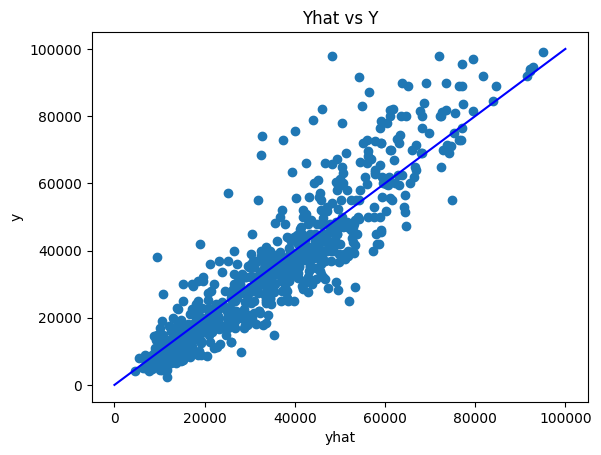

In [696]:
y_hat = model_result_xgboost.predict(X_test) #Predict values with selected model (test set)
y_hat_2 = model_result_xgboost.predict(X_train) #Predict values with selected model (train set)

plt.title("Yhat vs Y")
plt.plot(y_hat, y_test,"o")
plt.plot([0,100000],[0,100000],"b")
plt.xlabel("yhat")
plt.ylabel("y")
plt.show()

##### Predicted vs Actual Plot (Based on train sample)

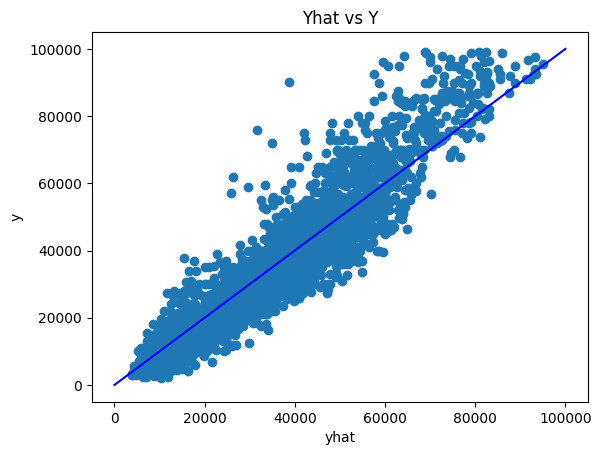

In [698]:
plt.title("Yhat vs Y")
plt.plot(y_hat_2, y_train,"o")
plt.plot([0,100000],[0,100000],"b")
plt.xlabel("yhat")
plt.ylabel("y")
plt.show()

The plot demonstrates a strong fit for values below 50,000 in the test sample, indicating that the model performs well within this range. However, for values exceeding 50,000, there is a noticeable decline in performance, though the predictions still follow an acceptable trend."

#### Residual Plots

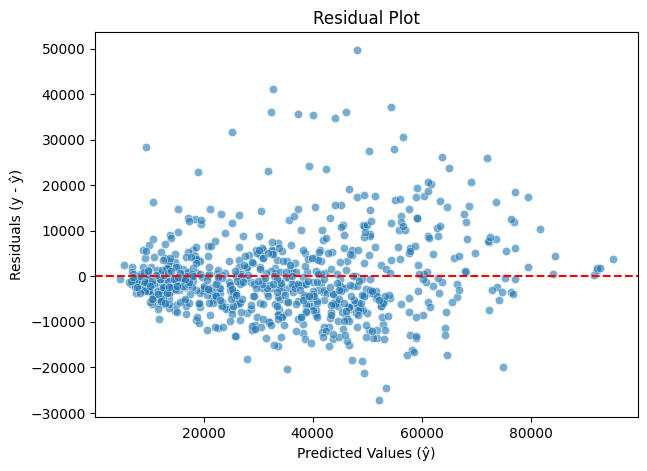

In [700]:
def plot_residuals(y_test, y_hat):
    residuals = y_test - y_hat
    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=y_hat, y=residuals, alpha=0.6)
    plt.axhline(y=0, color="red", linestyle="--")
    plt.xlabel("Predicted Values (ŷ)")
    plt.ylabel("Residuals (y - ŷ)")
    plt.title("Residual Plot")
    plt.show()

# Call function
plot_residuals(y_test, y_hat)

There are no visible patterns in the residual graph; however, it is evident that the model’s accuracy declines when predicting values exceeding approx. 50,000 USD. 